In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercise 2: Data linkage

In this exercise we want to evaluate the impact of duplicated patients in a dataset (*i.e.*, a patient having two or more digital identities). To address this issue, linkage algorithms may be used to merge records related to the same patient. They are commonly divided in **deterministic linkage** algorithms and in **probabilistic linkage** algorithms. Whereas deterministic algorithms rely on simple rules to match identifiers, probabilistic algorithms compute a similarity metric between pairs of records. A table of deduplicated patient identifiers is provided for examples of these two algorithms. 

In this exercice, we will : 
1. Deduplicate the dataset by using a deterministic algorithm
2. Deduplicate the dataset by using a probabilistic algorithm
3. Compare the Kaplan-Meyer curves between these 2 groups and non deduplicated data from exercice 1.

We initialize the notebook by importing the following libraries:

In [3]:
import pandas as pd
import numpy as np

# Visualization library
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

# Dates management
import datetime

# Table of content

# 1. Data Exploration


A fake dataset that mimics data coming from a clinical information system is made available in the */data* folder of this exercise.
<br>For this study, data has been extracted from the Clinical Data Warehouse on December 1st, 2025.
<br>The same data than in exercice 1 is imported

## 1.1 Data extracted from the Clinical Data Warehouse

Open the following files using the `pandas.read_pickle()` function : 
  - *data/df_person.pkl* as `df_person`
  - *data/df_visit.pkl* as `df_visit`
  - *data/df_condition.pkl* as `df_cond`
  - *data/df_med.pkl* as `df_med`


In [4]:
# Patients
df_person = pd.read_pickle('data/df_person.pkl')

# Visits
df_visit = pd.read_pickle('data/df_visit.pkl')

# Diagnosis (condition)
df_cond = pd.read_pickle('data/df_condition.pkl')

# Medication
df_med = pd.read_pickle('data/df_med.pkl')

## 1.2 Data provided by the deterministic deduplication algorithm

The results of the **deterministic algorithm** are made available in the *df_dedup_det* dataframe.

- Open the *data/df_dedup_deterministic.pkl* file as `df_dedup_det` using the `pandas.read_pickle()` function.
- Explore the type of each feature of the df_dedup_det DataFrame with the `.info()` function.
- Check out the first rows of the DataFrame using the `.head()` function.


In [5]:
df_dedup_det = pd.read_pickle('data/df_dedup_deterministic.pkl')
df_dedup_det.info()
df_dedup_det.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2031 entries, 2426 to 2544
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   unique_person_id  2031 non-null   int64
 1   person_id         2031 non-null   int64
dtypes: int64(2)
memory usage: 47.6 KB


,unique_person_id,person_id
2426,86935580,89600956
3202,89678041,89370306
1258,80366558,81161078
3196,86838212,84081330
2362,86219077,82689812


<br> The dataframe `df_dedup_det` is composed of 2 columns :
- *unique_person_id* : this id is the *real* id for the patient
- *person_id* : this id is another one, created by mistake

## 1.3 Data provided by the probabilistic deduplication algorithm

The results of the **probabilistic algorithm** are made available in the *df_dedup_proba* dataframe.

- Open the *data/df_dedup_proba.pkl* file as `df_dedup_proba` using the `pandas.read_pickle()` function.
- Explore the type of each feature of the df_dedup_proba DataFrame with the `.info()` function.
- Check out the first rows of the DataFrame using the `.head()` function.


In [6]:
df_dedup_proba = pd.read_pickle('data/df_dedup_proba.pkl')
df_dedup_proba.info()
df_dedup_proba.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6768 entries, 342 to 250
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   unique_person_id  6768 non-null   int64  
 1   person_id         6768 non-null   int64  
 2   prob              6768 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 211.5 KB


,unique_person_id,person_id,prob
342,86193754,80202898,1.000000
134,89565716,89561329,0.504925
386,83373840,88459191,0.694726
134,89022582,86442109,0.282641
109,87870541,82927006,0.954033


In [7]:
df_dedup_proba[df_dedup_proba["person_id"] != df_dedup_proba["unique_person_id"]]

,unique_person_id,person_id,prob
342,86193754,80202898,1.000000
134,89565716,89561329,0.504925
386,83373840,88459191,0.694726
134,89022582,86442109,0.282641
109,87870541,82927006,0.954033
...,...,...,...
279,81529552,88854847,1.000000
99,88724698,83949365,1.000000
654,84079378,80490869,0.465841
594,80071063,82741863,0.642474


<br> The dataframe `df_dedup_proba` is composed of 3 columns :
- *unique_person_id* : this id is the *real* id for the patient
- *person_id* : this id is another one, created by mistake
- *prob* : the probability that the 2 these 2 ids are actually the same person

# 2. Preprocessing

## 2.1 Deduplicating using the deterministic algorithm


<br> The dataframe `df_dedup_det` is composed of 2 columns :
- *unique_person_id* : this id is the *real* id for the patient
- *person_id* : this id is another one, created by mistake

We are going to clean the `df_person` dataframe by only keeping a single id per patient.
- Create a dataframe `df_person_dedup_det` from `df_person` that contains 1 row per patient.

TIPS : 
- Outer join `df_person` and `df_dedup_det` on *person_id* using the `pandas.merge()` function (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html))
- Fill in the *unique_person_id* column with the *person_id* column when empty using the `pandas.fillna()` function (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html))
- If several rows have the same *unique_person_id*, only keep the first one using `pandas.drop_duplicates()` (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html))

In [8]:
# Outer Join
df_person_dedup_det = pd.merge(df_person, df_dedup_det, on = 'person_id', how = 'outer')

# Complete the unique_person_id column
df_person_dedup_det['unique_person_id'] = df_person_dedup_det['unique_person_id'].fillna(df_person_dedup_det['person_id'])

# Only keep one row per patient
df_person_dedup_det = df_person_dedup_det.drop_duplicates(['unique_person_id'], keep = 'first')

How many patients have we left ?

In [9]:
print(f"We have {df_person_dedup_det.unique_person_id.nunique()} unique patient ids in this dataset when using the determinist algorithm.")

We have 64737 unique patient ids in this dataset when using the determinist algorithm.


## 2.2 Deduplicatng using probabilistic algorithm

<br> The dataframe `df_dedup_proba` is composed of 3 columns :
- *unique_person_id* : this id is the *real* id for the patient
- *person_id* : this id is another one, created by mistake
- *prob* : the probability that the 2 these 2 ids are actually the same person

Observe the distribution of the probabilities using `pandas.describe()` function

In [10]:
df_dedup_proba['prob'].describe()

count    6768.000000
mean        0.756597
std         0.308227
min         0.000218
25%         0.546009
50%         0.927391
75%         1.000000
max         1.000000
Name: prob, dtype: float64

Plot the estimated density of the distribution of the probabilities using `pandas.plot.density()` (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.density.html))

[]

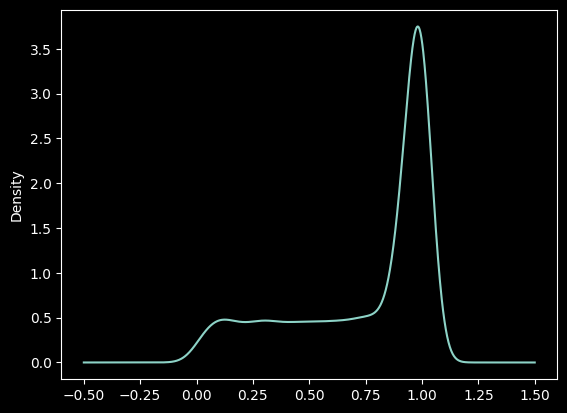

In [11]:
df_dedup_proba['prob'].plot.density()
plt.plot()

Why is there a peak at probability = 1?

**Correction** :
<br>The algorithm matches correctly all the patients that were matched in the deterministic algorithm.
<br>The peak is the result of the patient for whom we are sure the match is correct.

Create a function `deduplicate_proba(df_person: pd.DataFrame, df_dedup_proba: pd.DataFrame, score: int)` that returns a dataset of deduplicated person ids if their similarity score was above `score`.

TIPS : 
- Create a subset dataframe `df_dedup_proba_score` of df_person_dedup_proba keeping only rows where `'prob' > score`
- Outer join `df_person` and `df_dedup_proba_score` on *person_id* using the `pandas.merge()` function (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html))
- Fill in the *unique_person_id* column with the *person_id* column when empty using the `pandas.fillna()` function (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html))
- If several rows have the same *unique_person_id*, only keep the first one using `pandas.drop_duplicates()` (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html))

In [12]:
def deduplicate_proba(df_person: pd.DataFrame, df_dedup_proba: pd.DataFrame, score: int):
    #Only keep rows with a probability above the value score
    df_dedup_proba_score = df_dedup_proba[df_dedup_proba['prob'] > score]
    # Outer Join
    df_person_dedup_proba  = pd.merge(df_person, df_dedup_proba_score, on = 'person_id', how = 'outer')
    # Only unique ids in unique_person_id
    df_person_dedup_proba['unique_person_id'] = df_person_dedup_proba['unique_person_id'].fillna(df_person_dedup_proba['person_id'])
    # Only keep one row per patient
    df_person_dedup_proba = df_person_dedup_proba.drop_duplicates(['unique_person_id'], keep = 'first')
    return df_person_dedup_proba

Create a dataframe `df_person_dedup_proba_90` that only keeps the similarity scores above 0.90.<br>
How many patients do we have if the similarity score must be above 0.90 ?

In [13]:
df_person_dedup_proba_90 = deduplicate_proba(df_person, df_dedup_proba, score=0.90)
print(f"We have {df_person_dedup_proba_90.unique_person_id.nunique()} unique patient ids in this dataset when using the probabilistic algorithm and a threshold of 0.90.")

We have 62865 unique patient ids in this dataset when using the probabilistic algorithm and a threshold of 0.90.


Create a dataframe `df_person_dedup_proba_20` that only keeps the similarity scores above 0.20.<br>
How many patients do we have if the similarity score must be above 0.20 ?

In [14]:
df_person_dedup_proba_20 = deduplicate_proba(df_person, df_dedup_proba, score = 0.20)
print(f"We have {df_person_dedup_proba_20.unique_person_id.nunique()} unique patient ids in this dataset when using the probabilistic algorithm and a threshold of 0.20.")

We have 60624 unique patient ids in this dataset when using the probabilistic algorithm and a threshold of 0.20.


We can see that most linked records feature a high similarity score, but a significant amount of additional records would be matched by setting a low threshold. Let's compare two strategies for threshold setting, a high threshold strategy (*i.e.* keeping only high-confidence linkages, but missing some records that should be matched) and a low threshold strategy (*i.e.* linking most records that feature some similarities, among which some linkages correspond actually to different visits). 
<br>We choose as thresholds the values **0.9** and **0.2** to compare the consequences of both thresholds.

# 3. Statistical analysis

Now that we have deduplicated patient ids,  we can conduct the statistical analysis showing the impact of the deduplication process. 
<br>We plot the Kaplan-Meier estimates of survival curves, and realize the log-rank tests.
<br> The same functions `plot_primary_kaplan` used in the previous notebook can be used to plot the curves.
<br> If needed, you can print the docstrings using `print(plot_primary_kaplan.__doc__)`.

For this exercise, we have only kept the visits regarding the epidemic conditions. `df_visit` and `df_med` can be used to without any preprocessing.

In [15]:
t_end_of_study = datetime.date(2025,12,1)

In [1]:
 #Import the helper functions
import sys
sys.path.append("../")
from viz import plot_primary_kaplan, plot_secondary_kaplan

In [18]:
print(plot_primary_kaplan.__doc__)


    Function that displays survival curves computed by the KaplanMeierFitter function from the lifeline package. 
    It compares the drugA and drugB effects to the control cohort.

    Parameters
    ----------
    :param df_person_kaplan: pandas df,
        DataFrame gathering the demographic data about the patients of interest.
        Must have the same structure as the initial `df_person` table (must contain especially `person_id`
        and potential `death_datetime`).
    :param list_case: list of tuples,
        List of studied case for the survival analysis.
        List of tuple (df_visit-pandas df-, df_med-pandas df-, name-str-) having :
            - df_visit : hospitalization DataFrame, with information on entry/exit dates
            - df_med : drug administration DataFrame, must contain ONLY the drugs of interest (i.e epidemic)
            - name : name of the studied case (for visualization purposes)
    :param t_end_of_study: datetime.date,
        Date of the end of

## 3.1 Without deduplicating the person dataset

Plot the  primary Kaplan-Meier estimates for the whole `df_person` DataFrame

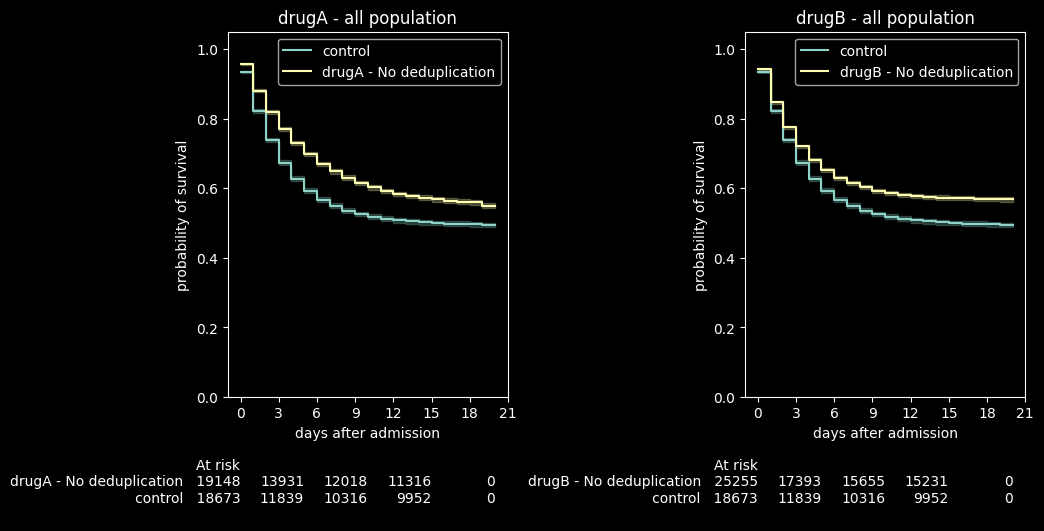

In [19]:
plot_primary_kaplan(
    df_person,
    [(df_visit, df_med, 'No deduplication')],
    t_end_of_study
    )

What can be concluded on the effect of each drugs?

**Correction** :
<br> It seems that both drugs have a positive impact on the survival of the patients.

## 3.2 Using the determinist deduplication

Plot the  primary Kaplan-Meier estimates for the whole `df_person_dedup_det` dataFrame

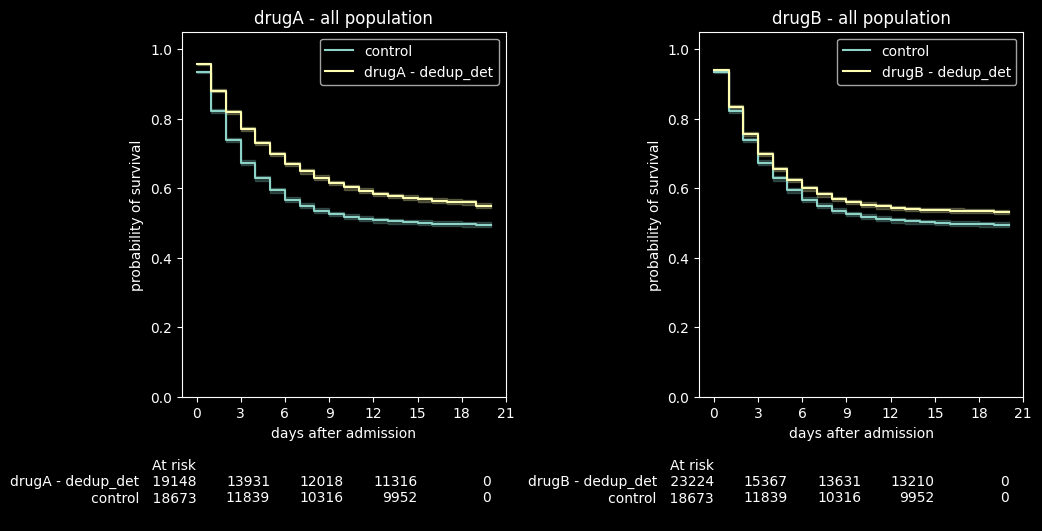

In [20]:
plot_primary_kaplan(
    df_person_dedup_det,
    [(df_visit, df_med, 'dedup_det')],
    t_end_of_study
    )

What can be concluded on the effect of each drugs?

**Correction** :
<br> It seems that both drugs have a positive impact on the survival of the patients
<br> However, the effect of drug B seems to be more moderated. 

## 3.2 Using the probabilistic deduplication

Plot the  primary Kaplan-Meier estimates for the whole `df_person_dedup_proba_90` dataFrame

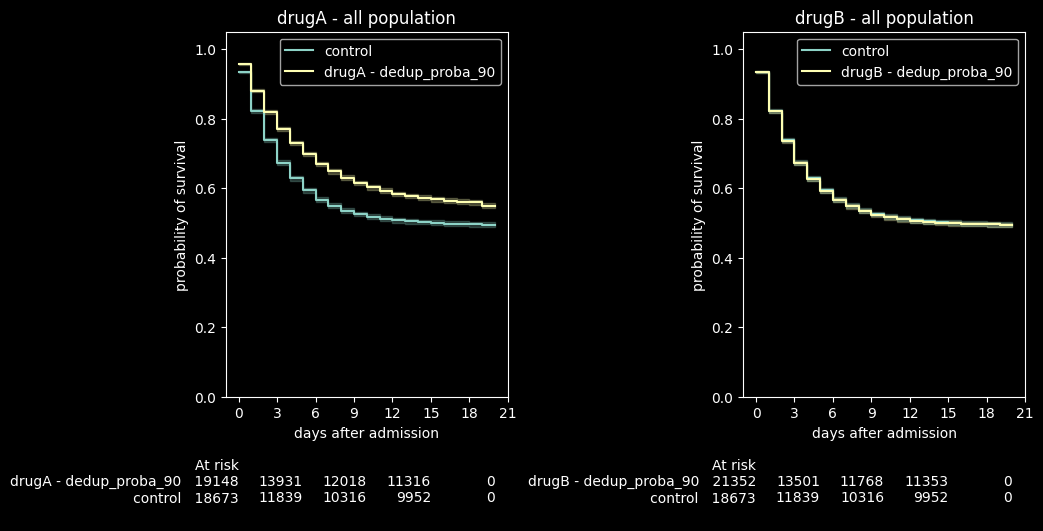

In [21]:
plot_primary_kaplan(
    df_person_dedup_proba_90, 
    [(df_visit, df_med, 'dedup_proba_90')], 
    t_end_of_study
)

What can be concluded on the effect of each drugs?

**Correction** :
<br> It seems that both drugs have a positive impact on the survival of the patients
<br> However, the effect of drug B seems to be even more moderated. 

Plot the  primary Kaplan-Meier estimates for the whole `df_person_dedup_proba_20` dataFrame

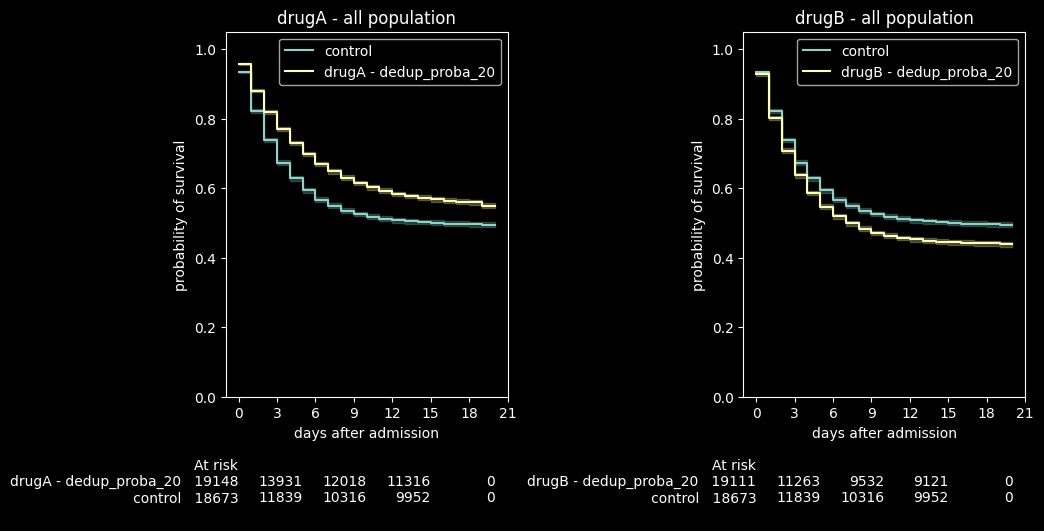

In [22]:
plot_primary_kaplan(
    df_person_dedup_proba_20, 
    # df_cond, 
    [(df_visit, df_med, 'dedup_proba_20')], 
    t_end_of_study
)

The survival curves obtained with the low value threshold diverge strongly from the high value threshold or from the survival curves computed using the deterministic algorithm. Our confidence in the low value threshold is therefore low, but we should keep investigating this issue, for instance realizing a validation of the probabilistic linkage by a chart review campaign.

In this exercise, we have shown some challenges related to the linkage of records in a clinical data warehouse. Various strategies may be adopted, and this methodological choice once more impacts the final results. 

# 4. Takeaways

- Clinical data warehouses contain **data collected in various clinical softwares** that may not always share **common identifiers**.
- It appears necessary to **link data coming from different softwares** prior to they statistical analysis (linkage to a common identity, to a visit occurrence, etc.). Linkage may rely on common identifiers or on more involved linkage algorithms.
- Linkage algorithms are commonly divided in **deterministic linkage** algorithms and in **probabilistic linkage** algorithms. Whereas deterministic algorithms rely on simple rules to match identifiers, probabilistic algorithms compute a similarity metric between pairs of records.
- Methodological choices related to data linkage may impact the result of the overall analysis

# 5. References

- Harron, Katie, Harvey Goldstein, et Chris Dibben. Methodological Developments in Data Linkage. Wiley Series in Probability and Statistics. Wiley, 2016.
- Harron, Katie, Angie Wade, Ruth Gilbert, Berit Muller-Pebody, et Harvey Goldstein. « Evaluating Bias Due to Data Linkage Error in Electronic Healthcare Records ». BMC Medical Research Methodology 14, nᵒ 1 (décembre 2014): 36. https://doi.org/10.1186/1471-2288-14-36.
- Gilbert, Ruth, Rosemary Lafferty, Gareth Hagger-Johnson, Katie Harron, Li-Chun Zhang, Peter Smith, Chris Dibben, et Harvey Goldstein. « GUILD: GUidance for Information about Linking Data Sets† ». Journal of Public Health 40, nᵒ 1 (1 mars 2018): 191‑98. https://doi.org/10.1093/pubmed/fdx037.
- Vatsalan, Dinusha, Peter Christen, et Vassilios S. Verykios. « A Taxonomy of Privacy-Preserving Record Linkage Techniques ». Information Systems 38, nᵒ 6 (septembre 2013): 946‑69. https://doi.org/10.1016/j.is.2012.11.005.